# Clustering S&P 500 Stocks Based on Valuation Metrics

## Import libraries and data
Pandas allows us to import data, requests will allows us to retrieve data from the TD Ameritrade API and config is the python file in the project folder that contains my TD Ameritrade API client id.

In [1]:
import pandas as pd
import requests
from config import client_id

CSV file download link: https://pkgstore.datahub.io/core/s-and-p-500-companies/constituents_csv/data/779b551ca54db43326b8035fca52cb1e/constituents_csv.csv

In [2]:
path = 'constituents_csv.csv'
stock_symbols = pd.read_csv(path)
stock_symbols.shape

(505, 3)

Divide the list of stocks into 100s because TD Ameritrade's API will have errors if too many stocks are passed in at the same time.

In [3]:
# Define the size of the chunks
n = 100

# Break the dataframe into chunks
symbols_chunk = [stock_symbols[i:i+n] for i in range(0, stock_symbols.shape[0], n)]
symbols_chunk[0]

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
95,CE,Celanese,Materials
96,CNC,Centene Corporation,Health Care
97,CNP,CenterPoint Energy,Utilities
98,CERN,Cerner,Health Care


In [4]:
# Grab an example to see the chunk
example_chunk = list(symbols_chunk[0]['Symbol'])

example_chunk[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD']

## Get a dataset of fundamentals from TD Ameritrade

In [5]:
# define an endpoint, in this case we will use the instruments endpoint
endpoint = r"https://api.tdameritrade.com/v1/instruments"

# we need a place to store all of our data, so a dictionary will do.
stock_dict = {}

# loop through each chunk
for chunk in symbols_chunk:
    
    # define the payload
    payload = {'apikey':client_id,
               'projection':'fundamental',
               'symbol':list(chunk['Symbol'])}
    
    # make a request
    content = requests.get(url = endpoint, params = payload)

    # convert it dictionary object
    data = content.json()

    # the ones that do exist, loop through each stock, grab the data, and store it in the dictionary
    try:
        for stock in data:
            stock_dict[data[stock]['cusip']] = data[stock]['fundamental']
    except:
        continue

In [6]:
# Create dataframe in newly collected data
stock_df = pd.DataFrame(stock_dict)

# Save a csv copy of the dataset
stock_df.to_csv('new_symbols.csv')

## Preprocessing the data

In [7]:
# Transpose the data
stock_df = stock_df.transpose()

# Display data
display(stock_df.head())

# Display shape (There are over 500 stocks because some companies have different classes of shares)
display(stock_df.shape)

,symbol,high52,low52,dividendAmount,dividendYield,dividendDate,peRatio,pegRatio,pbRatio,prRatio,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
14448C104,CARR,58.89,28.79,0.48,0.93,2021-06-23 00:00:00.000,18.39751,0.206672,6.63876,2.27269,...,0.0,0.0,0.0,0.0,0.12,2021-08-10 00:00:00.000,0.0,5879610.0,5879612.0,93667810.0
156782104,CERN,84.2,66.75,0.88,1.2,2021-09-24 00:00:00.000,32.153,0.854441,5.4556,3.86596,...,5.18097,0.0,0.0,0.0,0.22,2021-10-12 00:00:00.000,0.72149,2500170.0,2500168.0,47379160.0
037833100,AAPL,157.26,103.1,0.88,0.61,2021-08-06 00:00:00.000,28.08977,0.508559,36.94403,6.82958,...,0.0,0.0,0.0,0.0,0.22,2021-08-12 00:00:00.000,1.2196,96481690.0,96481691.0,1676171330.0
115637209,BF/B,82.24,67.74,0.718,1.04,2021-09-02 00:00:00.000,42.8444,0.0,12.26301,8.96737,...,9.92369,0.0,0.0,0.0,0.1795,2021-10-01 00:00:00.000,0.80284,1288230.0,1288226.0,18571040.0
031162100,AMGN,276.69,210.28,7.04,3.27,2021-08-16 00:00:00.000,21.89673,0.0,14.87439,4.7988,...,0.0,0.0,0.0,0.0,1.76,2021-09-08 00:00:00.000,0.67846,2850130.0,2850127.0,50764690.0


(505, 46)

Choose only the desired valuation metrics to use for the analysis and drop any rows with missing data

In [8]:
# Define the indicator list
metrics_list = ['peRatio', 'pbRatio', 'pcfRatio', 'symbol']

# Select only columns we need
indicators_df = stock_df[metrics_list]

# Remove missing values
indicators_df = indicators_df[indicators_df[metrics_list] != 0]
indicators_df = indicators_df.dropna(how = 'any')

# Display clean data
display(indicators_df)

,peRatio,pbRatio,pcfRatio,symbol
14448C104,18.39751,6.63876,15.63314,CARR
156782104,32.153,5.4556,15.3638,CERN
037833100,28.08977,36.94403,24.2428,AAPL
115637209,42.8444,12.26301,38.21709,BF/B
031162100,21.89673,14.87439,13.26961,AMGN
...,...,...,...,...
98389B100,21.57844,2.30323,9.11655,XEL
98956P102,32.00308,2.36876,14.9444,ZBH
989701107,8.31711,1.18315,19.29858,ZION
98978V103,50.32862,21.9129,40.48768,ZTS


Set the symbol attribute as the index and change the rest of the dataframe to a float data type

In [9]:
indicators_df = indicators_df.set_index('symbol')
indicators_df = indicators_df.astype('float')
indicators_df.head()

,peRatio,pbRatio,pcfRatio
symbol,,,
CARR,18.39751,6.63876,15.63314
CERN,32.15300,5.45560,15.36380
AAPL,28.08977,36.94403,24.24280
BF/B,42.84440,12.26301,38.21709
AMGN,21.89673,14.87439,13.26961


Show info on datatypes and the new shape. Notice we now have 436 stocks instead of 505

In [10]:
display(indicators_df.info(), indicators_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, CARR to ZBRA
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   peRatio   436 non-null    float64
 1   pbRatio   436 non-null    float64
 2   pcfRatio  436 non-null    float64
dtypes: float64(3)
memory usage: 13.6+ KB


None

(436, 3)

### Descriptive statistics are showing extremely high max values compared to the mean. Data must be severly skewed. We will plot histograms to confirm, then deal with any outliers.

In [11]:
# Show descriptive statisitics 
display(indicators_df.describe())

,peRatio,pbRatio,pcfRatio
count,436.000000,436.000000,436.000000
mean,44.853123,9.827881,22.080855
std,96.104993,19.886767,20.502538
min,5.287940,0.437170,2.079970
25%,17.646227,2.301530,10.128025
50%,26.937095,4.228245,17.469585
75%,42.607242,9.170210,25.194902
max,1337.011000,192.833500,227.659100


In [12]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Plotting three histograms on different subplots, we can see the data is severly skewed for all attributes.

Saving figure hist_with_outliers


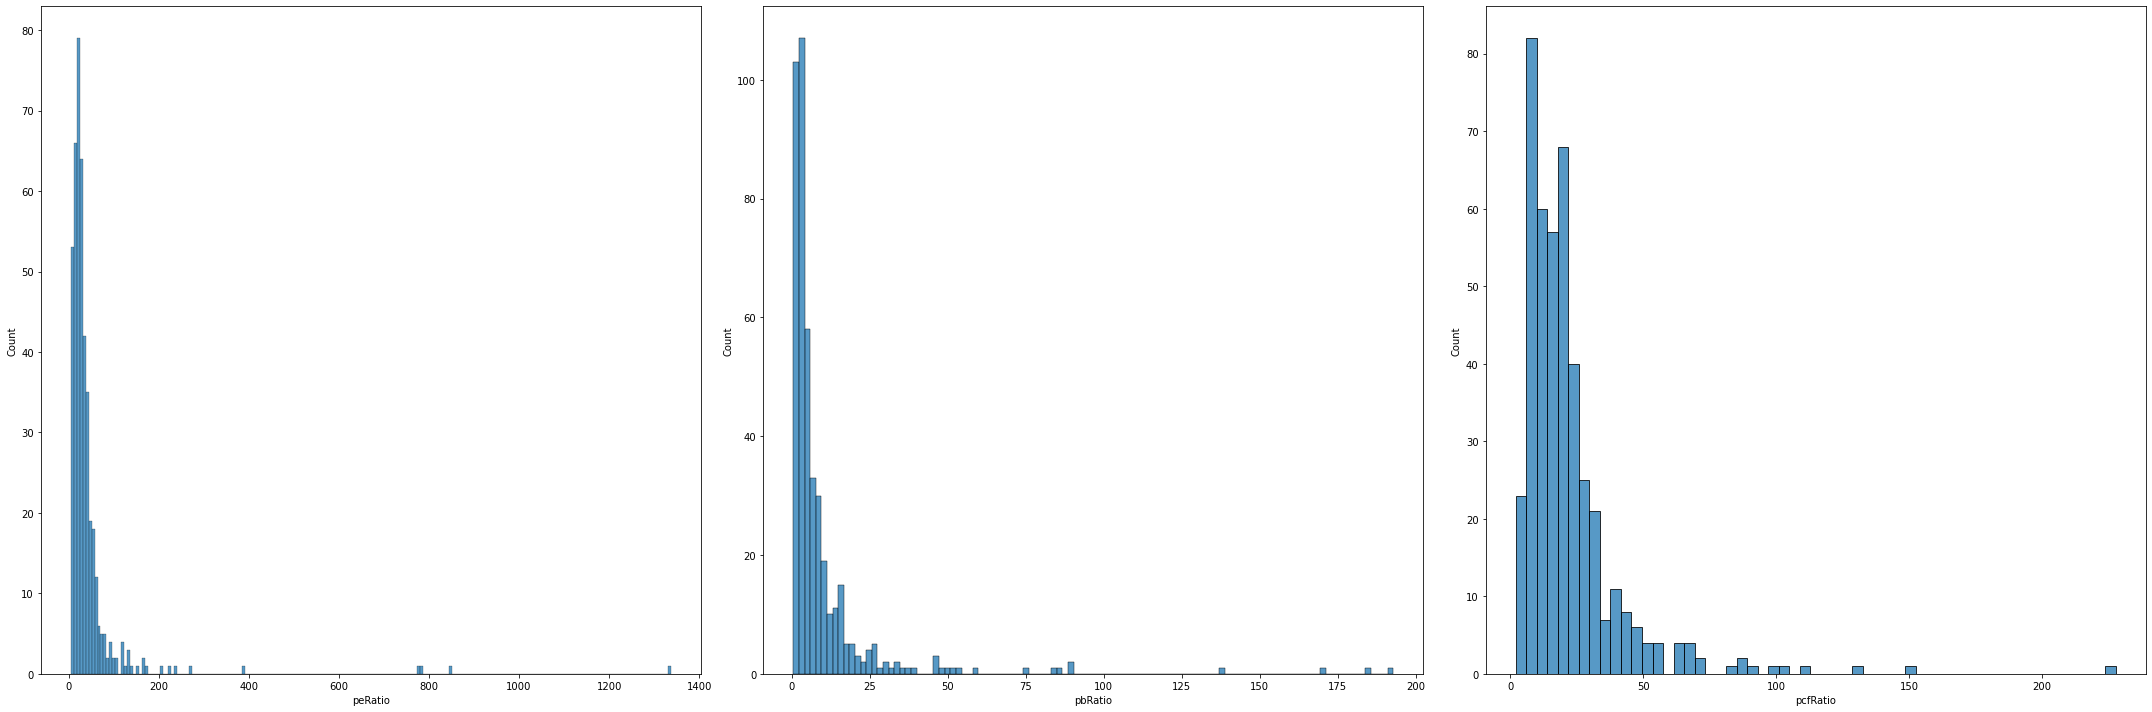

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(30, 10))
sns.histplot(x=indicators_df['peRatio'], ax=ax)
sns.histplot(x=indicators_df['pbRatio'], ax=ax1)
sns.histplot(x=indicators_df['pcfRatio'], ax=ax2)
save_fig(fig_id='hist_with_outliers')

Use the stats library to calculate z scores and the numpy library to make the values absolute.

In [14]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(indicators_df))
print(z)

         peRatio   pbRatio  pcfRatio
symbol                              
CARR    0.275594  0.160548  0.314845
CERN    0.132300  0.220111  0.327997
AAPL    0.174628  1.365094  0.105569
BF/B    0.020925  0.122590  0.787940
AMGN    0.239142  0.254054  0.430257
...          ...       ...       ...
XEL     0.242458  0.378809  0.633053
ZBH     0.133862  0.375510  0.348477
ZION    0.380604  0.435197  0.135860
ZTS     0.057040  0.608390  0.898814
ZBRA    0.067352  0.069099  0.447618

[436 rows x 3 columns]


Filter the dataframe with z scores above 2 considered to be outliers and notice the change in the number of stocks, dropping down to 404.

In [15]:
indicators_df_o = indicators_df[(z < 2).all(axis=1)]
indicators_df_o.shape

(404, 3)

Saving figure hist_without_outliers


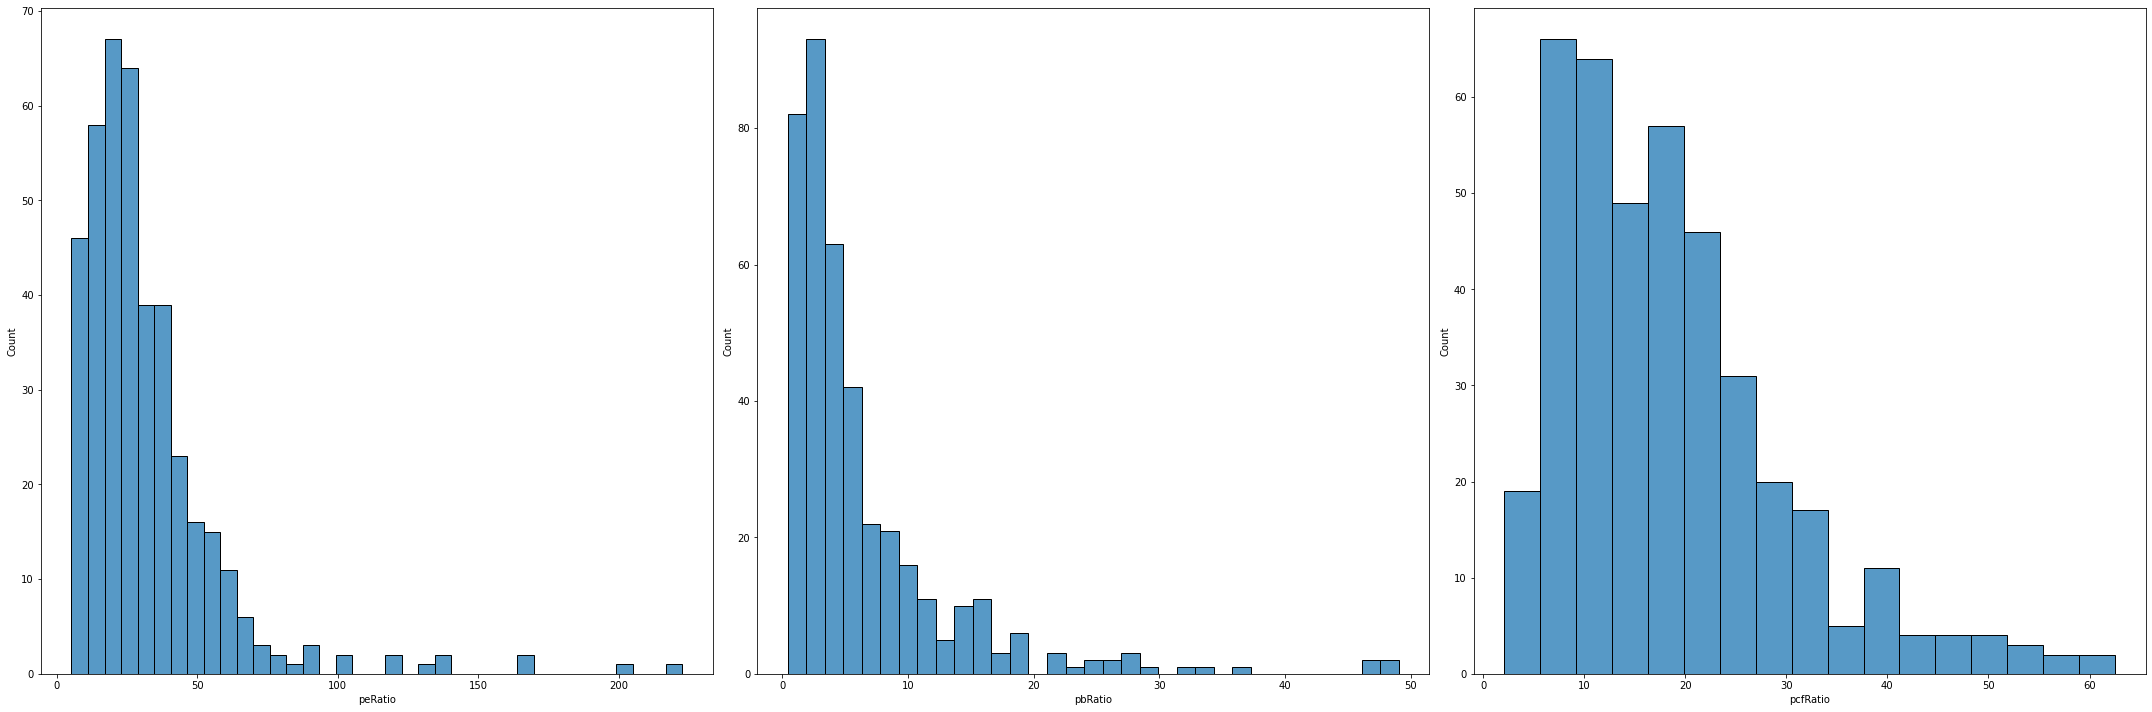

In [16]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(30, 10))
sns.histplot(x=indicators_df_o['peRatio'], ax=ax)
sns.histplot(x=indicators_df_o['pbRatio'], ax=ax1)
sns.histplot(x=indicators_df_o['pcfRatio'], ax=ax2)
save_fig(fig_id='hist_without_outliers')

Extreme values are much more manageable now.

In [17]:
# Describe the dataset again. 
indicators_df_o.describe()

,peRatio,pbRatio,pcfRatio
count,404.000000,404.000000,404.000000
mean,32.019606,6.450644,18.530625
std,25.971903,7.226710,11.079835
min,5.287940,0.437170,2.079970
25%,16.912128,2.227005,9.850373
50%,26.176415,3.922735,16.639880
75%,38.894905,7.804892,23.592257
max,222.551100,49.034200,62.529610


## Visualizing and scale the data
mpl toolkits allows us to plot 3d scatter plots

Saving figure 3d_scatter


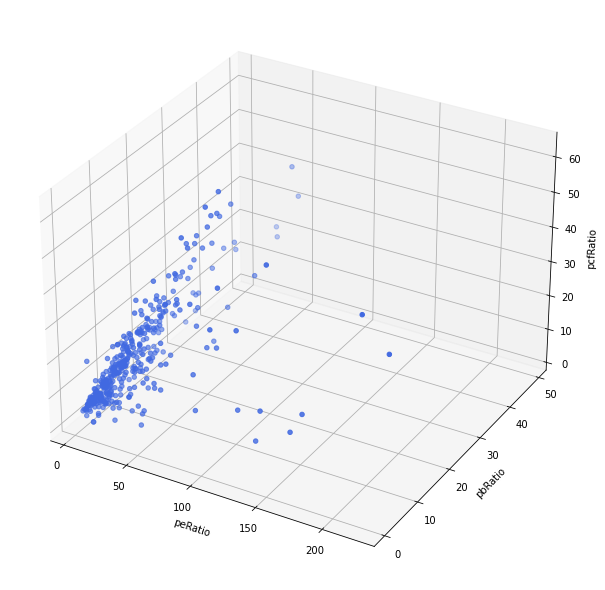

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Define our figure
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Define the x, y, & z of our scatter plot, this will just be the data from our data frame.
x = list(indicators_df_o.iloc[:,0])
y = list(indicators_df_o.iloc[:,1])
z = list(indicators_df_o.iloc[:,2])

# Define the axis labels
column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# Define the markers, and the color
ax.scatter(x, y, z, c='royalBlue', marker='o')

# Save plot
save_fig(fig_id='3d_scatter', tight_layout=False)

In order to prepare the data for the machine learning algorithm, it needs to be scaled. We will create instances of the min-max scaler, standard scaler, and robust scaler for demonstration but only use the robust scaler.

Saving figure 3d_scaled


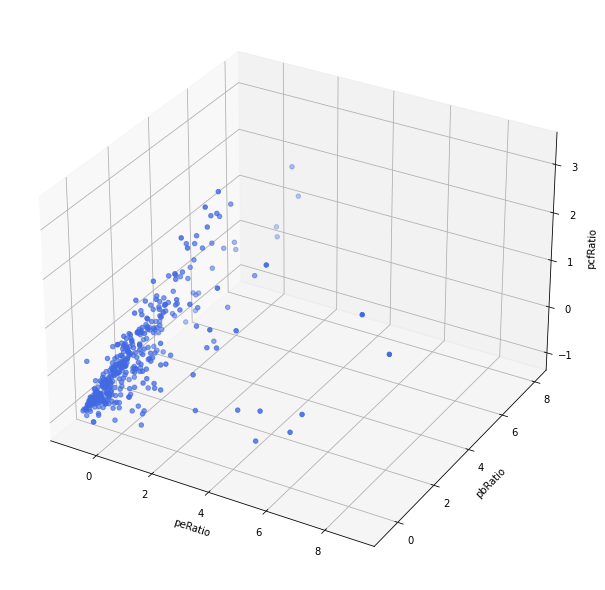

In [19]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# for demonstration purposes, I will be creating all three instances of the scalers.
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

# scale the data
X_train_minmax = min_max_scaler.fit_transform(indicators_df_o)
X_train_standard = std_scaler.fit_transform(indicators_df_o)
X_train_robust = robust_scaler.fit_transform(indicators_df_o)

# create a new plot
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# take the scaled data in this example.
x = X_train_robust[:,0]
y = X_train_robust[:,1]
z = X_train_robust[:,2]

# define the axes labels
column_names = indicators_df_o.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# create a new plot
ax.scatter(x, y, z, c='royalBlue')

save_fig(fig_id='3d_scaled', tight_layout=False)

I will run PCA analysis to check if it is necessary to carry on will all three metrics. The results show that about 95% of the variance can be explained by just two variables. No need to carry on with all three.

Text(0.5, 1.0, 'Explained Variance')

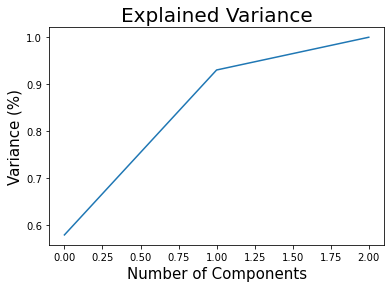

In [20]:
from sklearn.decomposition import PCA

# pass through the scaled data set into our PCA class object
pca = PCA().fit(X_train_robust)

# plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# define the labels & title
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15) 
plt.title('Explained Variance', fontsize = 20)

In [21]:
# create a PCA modified dataset
pca_dataset = PCA(n_components=2).fit(X_train_robust).transform(X_train_robust)

# store it in a new data frame
pca_dataset= pd.DataFrame(data = pca_dataset, columns = ['principal component 1', 'principal component 2'])

Saving figure 2_comp_pca


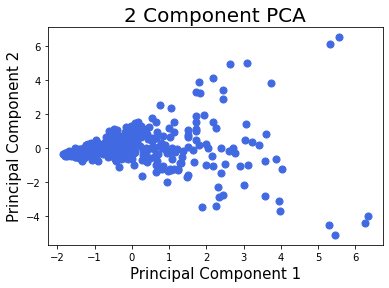

In [22]:
# define a figure
plt.figure()

# define the label and title
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA', fontsize = 20)

# plot the figure
plt.scatter(pca_dataset['principal component 1'], pca_dataset['principal component 2'], c='royalBlue', s = 50)

save_fig(fig_id='2_comp_pca', tight_layout=False)

## Build and Run the Model
The model will be built and run using both the original scaled data and the pca data. Silhouette scores will show us the distance between the clusters that resulted from the algorithm. The larger the clusters, the better the results. The PCA data below gives us better results.

In [23]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Create a dictionary to store our scores
results_dict = {}

# Set number of clusters
num_of_clusters = 7

# Define the number of iterations we want to do
for k in range (2, num_of_clusters): 
    
    print('-' * 100)
    
    # Define the key for this iteration
    results_dict[k] = {}
    
    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train_robust)
    
    # Create an instance of the kmeans model
    sil_score = metrics.silhouette_score(X_train_robust, kmeans.labels_, metric = 'euclidean')
    
    # Store the different metrics
    results_dict[k]['silhouette_score'] = sil_score
    results_dict[k]['inertia'] = kmeans.inertia_
    results_dict[k]['score'] = kmeans.score
    results_dict[k]['model'] = kmeans
    
    # Print the results    
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5357824264301079
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.5592885913198473
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.46507798829917024
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.3943308823827475
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.4082835582959722


In [24]:
# define a dictionary that contains all of our relevant info.
results_dict_pca = {}

# define how many clusters we want to test up to.
num_of_clusters = 7

# run through each instance of K
for k in range(2, num_of_clusters):
    
    print("-"*100)
    
    # define the next dictionary to hold all the results of this run.
    results_dict_pca[k] = {}

    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_dataset)
    
    # define the silhouette score
    sil_score = metrics.silhouette_score(pca_dataset, kmeans.labels_, metric='euclidean')
    
    # store the different metrics
    results_dict_pca[k]['silhouette_score'] = sil_score
    results_dict_pca[k]['inertia'] = kmeans.inertia_
    results_dict_pca[k]['score'] = kmeans.score
    results_dict_pca[k]['model'] = kmeans
    
    # print the results    
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5558694997380236
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.5823143394100831
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.4885206932655537
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.43153712564515717
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.45190639678872835


## Visualize the clusters
I will visualize the data with 3 clusters since that gave us the highest silhouette score. The cluster on the left is very dense.

Saving figure pca_clusters


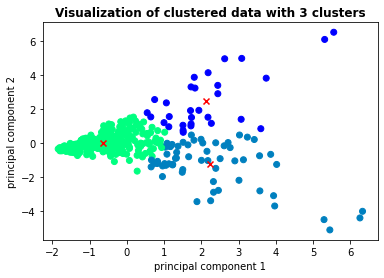

In [25]:
kmeans = KMeans(n_clusters= 3, random_state=0).fit(pca_dataset)

# Adding the clusters to the original dataset to show which stock is in which cluster
predict = kmeans.predict(pca_dataset)
predict = pd.Series(predict)
indicators_df_o = indicators_df_o.assign(pca_clusters=predict.values)
                    
# define the cluster centers
cluster_centers = kmeans.cluster_centers_
C1 = cluster_centers[:, 0]
C2 = cluster_centers[:, 1]

# create a new plot
plt.figure()

# take the scaled data in this example.
x = pca_dataset['principal component 1']
y = pca_dataset['principal component 2']

# define the axes labels
column_names = pca_dataset.columns
plt.xlabel(column_names[0])
plt.ylabel(column_names[1])

# Visualize it:
plt.scatter(x, y, c=kmeans.labels_.astype(float), cmap='winter')
plt.scatter(C1, C2, marker="x", color='r')

# Plot the clustered data
plt.title('Visualization of clustered data with {} clusters'.format(3), fontweight='bold')

save_fig(fig_id='pca_clusters', tight_layout=False)

Saving the dataset containing the stocks in their clusters

In [26]:
indicators_df_o.to_csv('indicators_with_clusters.csv')

Grouping and sorting the dataset by clusters and symbol

In [40]:
indicators_grouped = indicators_df_o.sort_values(by=['pca_clusters', 'symbol'])
display(indicators_grouped.sample(5))
indicators_grouped.to_csv('indicators_grouped.csv')

,peRatio,pbRatio,pcfRatio,pca_clusters
symbol,,,,
KHC,21.34306,0.87915,14.54948,2
CLX,29.58888,48.92388,21.62699,1
GPN,54.10486,1.72280,19.04019,2
HIG,11.50318,1.32155,8.52194,2
EOG,22.40299,2.01908,7.82691,2


### Using Plotly to display stock info when hovering over a point
The yellow cluster contains value stocks like GM, BRK, KO, and INTC, while the other clusters contain more growth stocks like CRM, AMZN, ISRG, and MSFT. Next step would be to compare the average performance accross the different clusters.

In [38]:
import plotly.express as px

x = pca_dataset['principal component 1']
y = pca_dataset['principal component 2']
hover_data = pca_dataset.index
fig = px.scatter(pca_dataset, x=x, y=y, color=kmeans.labels_.astype(float), hover_data=[indicators_df_o.index])
fig.show()